In [53]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout,BatchNormalization, AveragePooling2D, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras import regularizers
import os

import argparse
import cv2

## Importing data

In [6]:
df = pd.read_csv("data/fer2013.csv")

In [7]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
df.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [9]:
df.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [10]:
emotions_dict = {0:"Angry", 1:"Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5:"Surprise", 6:"Neutral"}
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [11]:
# Combining PublicTest and PrivateTest to the whole testing set
df_training = df[df["Usage"] == "Training"]
df_testing = df[df["Usage"] != "Training"]

In [12]:
# Save training set and testing set as csv file for the purpose of futher use
# Uncomment commands below if you need to save these files
#df_training.to_csv("data/train.csv", index = False)
#df_testing.to_csv("data/test.csv", index = False)

In [13]:
# create inputs and labels for the training set
def get_inputs_labels(file_path):
    df = pd.read_csv(file_path)
    inputs = [np.array(df["pixels"][i].split(" ")).astype(int) for i in range(df.shape[0])]
    labels = [df["emotion"][i] for i in range(df.shape[0])]
    assert len(inputs) == len(labels), "inputs and labels should have the same length."
    return np.array(inputs), np.array(labels)

In [14]:
def training_testing_prep(training_file_path, testing_file_path):
    image_size = 48
    training_inputs, training_labels = get_inputs_labels(training_file_path)
    testing_inputs, testing_labels = get_inputs_labels(testing_file_path)
    training_inputs = training_inputs.reshape(training_inputs.shape[0], image_size, image_size, 1)
    testing_inputs = testing_inputs.reshape(testing_inputs.shape[0], image_size, image_size, 1)
    training_labels = tf.one_hot(training_labels, 7, dtype=tf.float32)
    testing_labels = tf.one_hot(testing_labels, 7, dtype=tf.float32)
    
    return training_inputs, training_labels, testing_inputs, testing_labels

In [15]:
training_inputs, training_labels, testing_inputs, testing_label = training_testing_prep("data/train.csv", "data/test.csv")

In [16]:
# for ix in range(10):
#     plt.figure(ix)
#     need_pixel = []
#     for j in range(48):
#         need_pixel.append([training_inputs[ix][j][i][0] for i in range(48)])
#     plt.imshow(need_pixel, interpolation='none', cmap='gray')
#     plt.text(80, 30, emotions_dict[list(training_labels[ix].numpy()).index(1.0)], ha = "center")
#     plt.show()

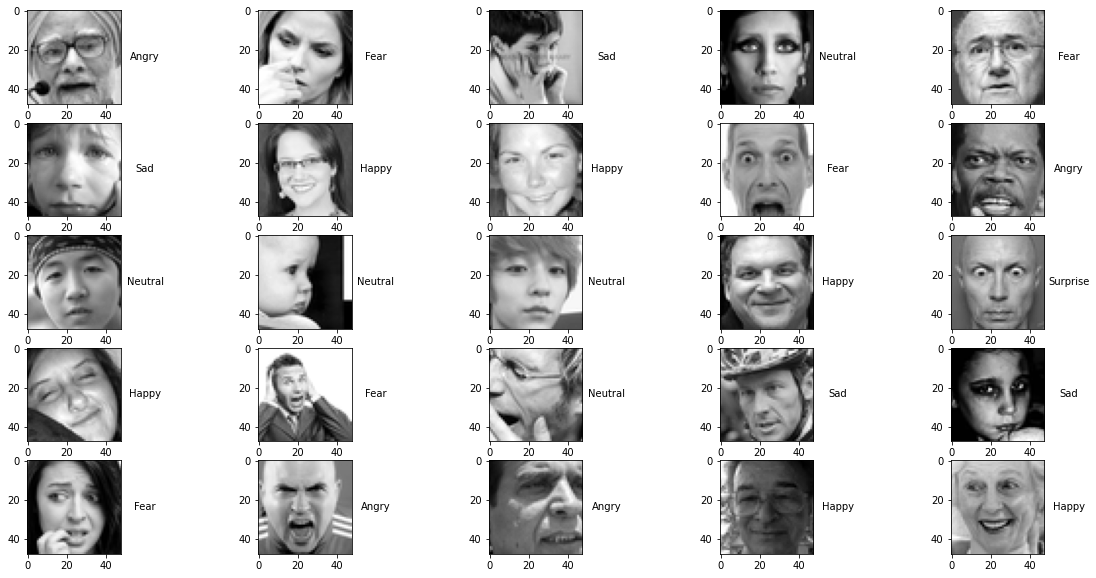

In [17]:
plt.figure(0, figsize=(20,10))
for i in range(1, 26):
    plt.subplot(5,5,i)
    plt.imshow(training_inputs[i, :, :, 0], cmap="gray")
    plt.text(60, 25, emotions_dict[list(training_labels[i].numpy()).index(1.0)], ha = "center")

#### Deep Learning: CNN Model

In [116]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(4, 4), padding = "same", activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(128, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), strides = (2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(4, 4), padding = "same", activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))


model.add(Conv2D(256, kernel_size=(4, 4), padding = "same", activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding = "same", activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Flatten())


model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam' ,
              metrics=['acc'])

print(model.summary())

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_218 (Conv2D)          (None, 48, 48, 64)        1088      
_________________________________________________________________
conv2d_219 (Conv2D)          (None, 48, 48, 128)       73856     
_________________________________________________________________
batch_normalization_121 (Bat (None, 48, 48, 128)       512       
_________________________________________________________________
activation_120 (Activation)  (None, 48, 48, 128)       0         
_________________________________________________________________
average_pooling2d_34 (Averag (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 24, 24, 64)        73792     
_________________________________________________________________
batch_normalization_122 (Bat (None, 24, 24, 64)      

In [117]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7) ,
              metrics=['acc'])

In [118]:
batch_size = 64
epochs = 20

In [119]:
history = model.fit(training_inputs, training_labels, 
                    batch_size=batch_size,
                    validation_data=(testing_inputs, testing_label),
                    epochs = epochs,
                    shuffle=True, 
                    verbose = 2)

Epoch 1/20


2022-05-05 00:01:10.069726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-05 00:01:32.620132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


449/449 - 24s - loss: 2.1070 - acc: 0.2134 - val_loss: 1.9527 - val_acc: 0.1792
Epoch 2/20
449/449 - 23s - loss: 1.8535 - acc: 0.2443 - val_loss: 1.7975 - val_acc: 0.2552
Epoch 3/20
449/449 - 23s - loss: 1.7582 - acc: 0.2908 - val_loss: 1.7522 - val_acc: 0.2823
Epoch 4/20
449/449 - 23s - loss: 1.6676 - acc: 0.3293 - val_loss: 1.7138 - val_acc: 0.3002
Epoch 5/20
449/449 - 23s - loss: 1.5556 - acc: 0.3820 - val_loss: 1.7633 - val_acc: 0.2615
Epoch 6/20
449/449 - 23s - loss: 1.4787 - acc: 0.4111 - val_loss: 1.4582 - val_acc: 0.4094
Epoch 7/20
449/449 - 23s - loss: 1.4206 - acc: 0.4299 - val_loss: 1.4531 - val_acc: 0.4337
Epoch 8/20
449/449 - 23s - loss: 1.3838 - acc: 0.4401 - val_loss: 1.3904 - val_acc: 0.4335
Epoch 9/20
449/449 - 23s - loss: 1.3539 - acc: 0.4541 - val_loss: 1.3968 - val_acc: 0.4505
Epoch 10/20
449/449 - 23s - loss: 1.3315 - acc: 0.4673 - val_loss: 1.3409 - val_acc: 0.4531
Epoch 11/20
449/449 - 23s - loss: 1.2968 - acc: 0.4873 - val_loss: 1.2758 - val_acc: 0.4969
Epoch 12

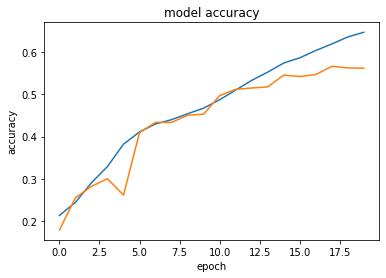

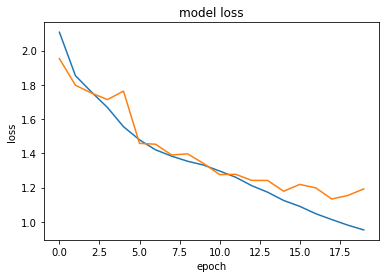

In [120]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [121]:
model.save('emotion_detection_model.h5')

In [97]:
import numpy as np
import argparse
import cv2
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout




model = tf.keras.models.load_model('emotion_detection_model.h5')
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}


cap = cv2.VideoCapture(0)
while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    if not ret:
        break
    facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img)
        maxindex = int(np.argmax(prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('Video', cv2.resize(frame,(1600,960),interpolation = cv2.INTER_CUBIC))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

2022-05-04 16:36:17.371090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [98]:
cap.release()
cv2.destroyAllWindows()